# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins. 

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1sInxoaiao3Ks14At_L72FzAZR7aTaeg1

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [ ]:
# Import libraries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ONLY NEED TO DO THIS UNZIPPING ONE TIME
# Unzip the dataset.zip file
!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Lab3 Dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/datasets'

Archive:  /content/drive/MyDrive/Colab Notebooks/APS360/Lab3 Dataset.zip
replace /content/drive/MyDrive/Colab Notebooks/APS360/datasets/Lab3 Dataset/Lab3_Gestures_Summer/test/A/1_A_2.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Colab Notebooks/APS360/datasets/Lab3 Dataset/Lab3_Gestures_Summer/test/A/108_A_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

After manually inspecting the folders from A-I and checking how many images each folder contains, I deduced that there were roughly 247 images per folder. In order to split this into training, validation, and testing data, I chose a 70-20-10 split. I had 172 images resorted for training, 50 images resorted for validation, and 25 images resorted for testing for every folder. Of course, some folders had more than 247 images and some folders had less, but I always ensured that my validation and testing data was 50 and 25 images each.

In [ ]:
# Transform Settings to get every image to 224x224 RGB size
transform_data = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# As described above, the train, validation and testing split is 70-20-10
train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/datasets/Lab3 Dataset/Lab3_Gestures_Summer/train', transform=transform_data)
validation_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/datasets/Lab3 Dataset/Lab3_Gestures_Summer/validate', transform=transform_data)
test_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/APS360/datasets/Lab3 Dataset/Lab3_Gestures_Summer/test', transform=transform_data)

# Print the number of images in each category after splitting
print('The number of images in the training dataset is: ', len(train_data))
print('The number of images in the validation dataset is: ', len(validation_data))
print('The number of images in the testing dataset is: ', len(test_data))


The number of images in the training dataset is:  1547
The number of images in the validation dataset is:  450
The number of images in the testing dataset is:  225


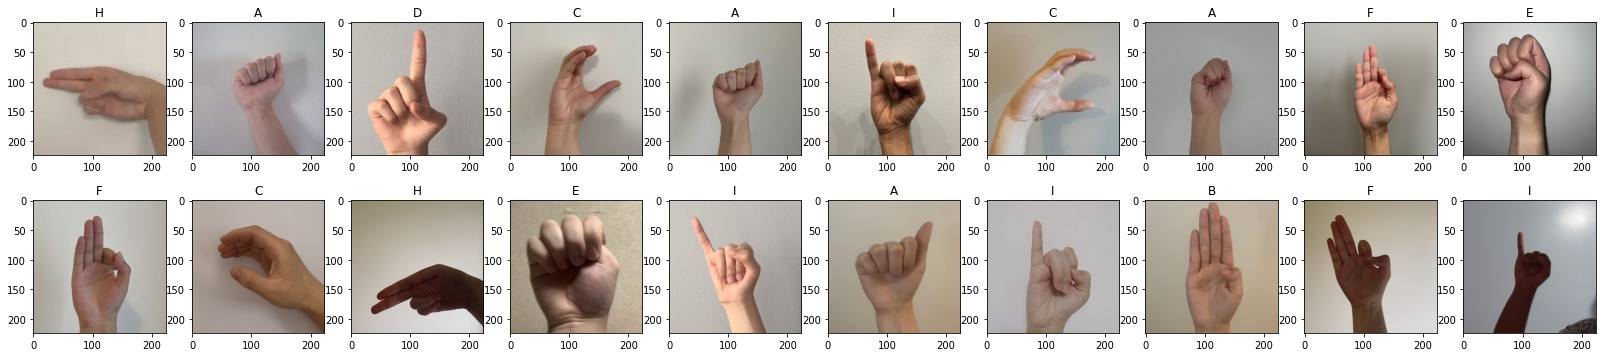

In [ ]:
# Load some of the train data just to verify the data is actually loaded
# Select an arbitrary batch size for sanity check sake
train_load = torch.utils.data.DataLoader(train_data, batch_size=20, num_workers=1, shuffle=True)
images, labels = iter(train_load).next()
images = images.numpy() 

# Folder names for the classes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# Plot the images and class labels
figure = plt.figure(figsize=(28, 6))
for i in np.arange(20):
    ax = figure.add_subplot(2, 10, i+1)
    ax.set_title(classes[labels[i]])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class Hands_CNN(nn.Module):
    def __init__(self):
        super(Hands_CNN, self).__init__()
        self.name = "Hands_CNN"
        # Input channel = 3, output channel = 10, kernel size = 5
        self.conv1 = nn.Conv2d(3, 10, 5)
        # Kernel size and stride are both 2
        self.pool = nn.MaxPool2d(2, 2)
        # Input channel = 10, output channel = 5, kernel size = 5
        self.conv2 = nn.Conv2d(10, 5, 5)
        # Input features = 14045, output features = 32
        self.fc1 = nn.Linear(53 * 53 * 5, 32)
        # Input features = 32, output features = 9
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53 * 53 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

My CNN has 2 convolution layers, a max pooling layer (of kernel size 2 and stride 2) and 2 fully connected layers. I have chosen ReLu as my activation function. This was inspried from the LargeNet implementation in Lab 2. I chose these choices for neural network architecture because many different features can be examined by my model, information after the convolution layers can be consolidated by the pooling layers, and 2 fully connected layers will identify patterns within the data and perform a classification.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
# From Tutorial 3

# Get accuracy function
def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    for images, labels in iter(data_loader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()

    output = model(images)

    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(labels.view_as(prediction)).sum().item()
    total += images.shape[0]

    return correct/total

# Train function
def train(model, train_data, validation_data, batch_size = 27, epochs = 1, learning_rate = 0.01):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

  torch.manual_seed(50) 

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  iters, losses, train_acc, val_acc = 0, [], [], []

  for epoch in range(epochs):
    for images, labels in iter(train_loader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()

      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      iters += 1

    train_acc.append(get_accuracy(model, train_loader))
    val_acc.append(get_accuracy(model, validation_loader))
    losses.append(float(loss)/batch_size)
    print('Epoch: ', epoch, 'Training Accuracy: ', train_acc[-1], 'Validation Accuracy: ', val_acc[-1])
  
  # Plot the graphs
  # Accuracy Plot
  plt.title("Training Curve")
  plt.plot(train_acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.show()

  # Loss Plot
  plt.title('Training Curve')
  plt.plot(losses, label='Training')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.show()

The criterion and optimizer chosen were cross entropy and SGD respectively. Cross entropy is the best criterion at our disposal for classification models and SGD optimizer is state-of-the-art and although Adam might seem like a more attractive option, I found that SGD generalizes data better per (https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008). Furthermore, SGD is what we used to learn in tutorials so I feel generally comfortable implementing it.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# ONLY NEED TO DO THIS UNZIPPING ONE TIME
# Unzip the Small Training Set.zip file
!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Small Training Set.zip' -d '/content/drive/MyDrive/Colab Notebooks/APS360/Small Set'

Archive:  /content/drive/MyDrive/Colab Notebooks/APS360/Small Training Set.zip
replace /content/drive/MyDrive/Colab Notebooks/APS360/Small Set/Small Training Set/Lab3_Gestures_Summer/train/A/2324_A_3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Colab Notebooks/APS360/Small Set/Small Training Set/Lab3_Gestures_Summer/train/A/2349_A_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Epoch:  0 Training Accuracy:  0.16666666666666666
Epoch:  1 Training Accuracy:  0.1111111111111111
Epoch:  2 Training Accuracy:  0.16666666666666666
Epoch:  3 Training Accuracy:  0.1111111111111111
Epoch:  4 Training Accuracy:  0.05555555555555555
Epoch:  5 Training Accuracy:  0.16666666666666666
Epoch:  6 Training Accuracy:  0.05555555555555555
Epoch:  7 Training Accuracy:  0.0
Epoch:  8 Training Accuracy:  0.16666666666666666
Epoch:  9 Training Accuracy:  0.0
Epoch:  10 Training Accuracy:  0.1111111111111111
Epoch:  11 Training Accuracy:  0.05555555555555555
Epoch:  12 Training Accuracy:  0.1111111111111111
Epoch:  13 Training Accuracy:  0.05555555555555555
Epoch:  14 Training Accuracy:  0.16666666666666666
Epoch:  15 Training Accuracy:  0.16666666666666666
Epoch:  16 Training Accuracy:  0.1111111111111111
Epoch:  17 Training Accuracy:  0.1111111111111111
Epoch:  18 Training Accuracy:  0.05555555555555555
Epoch:  19 Training Accuracy:  0.1111111111111111
Epoch:  20 Training Accuracy:

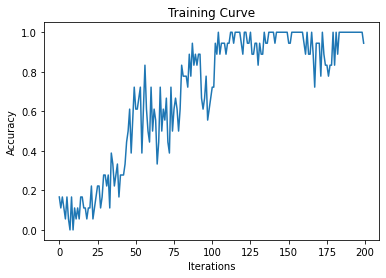

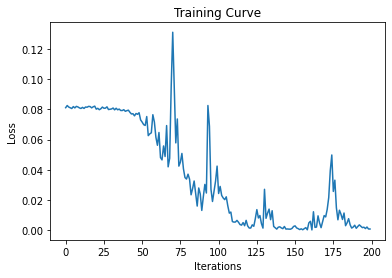

In [ ]:
small_data_path = '/content/drive/MyDrive/Colab Notebooks/APS360/Small Set/Small Training Set/Lab3_Gestures_Summer/train'

small_data = datasets.ImageFolder(small_data_path, transform=transform_data)
small_data_load = torch.utils.data.DataLoader(small_data, batch_size=27, shuffle=True)

torch.manual_seed(50)

myModel = Hands_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, momentum=0.9)

iters, losses, train_acc, val_acc = 0, [], [], []

for epoch in range(200):
  for images, labels in iter(small_data_load):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      myModel.cuda()

    output = myModel(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    iters += 1

  train_acc.append(get_accuracy(myModel, small_data_load))
  losses.append(float(loss)/27)
  print('Epoch: ', epoch, 'Training Accuracy: ', train_acc[-1])

# Plot the graphs

# Accuracy Plot
plt.title("Training Curve")
plt.plot(train_acc, label='Training')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

# Loss Plot
plt.title('Training Curve')
plt.plot(losses, label='Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

As we can see, my model achieves 100% accuracy with the train data which it has memorized. I had used 5 images in the small dataset for each folder for the overfitting task.

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.



1.   Learning Rate
2.   Batch Size
3.   Convolutional layer kernel size



### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

We are utilizing the GPU
Epoch:  0 Training Accuracy:  0.0 Validation Accuracy:  0.1111111111111111
Epoch:  1 Training Accuracy:  0.0 Validation Accuracy:  0.1111111111111111
Epoch:  2 Training Accuracy:  0.125 Validation Accuracy:  0.1111111111111111
Epoch:  3 Training Accuracy:  0.125 Validation Accuracy:  0.1111111111111111
Epoch:  4 Training Accuracy:  0.0 Validation Accuracy:  0.1111111111111111
Epoch:  5 Training Accuracy:  0.375 Validation Accuracy:  0.2222222222222222
Epoch:  6 Training Accuracy:  0.125 Validation Accuracy:  0.3888888888888889
Epoch:  7 Training Accuracy:  0.125 Validation Accuracy:  0.2222222222222222
Epoch:  8 Training Accuracy:  0.25 Validation Accuracy:  0.2777777777777778
Epoch:  9 Training Accuracy:  0.125 Validation Accuracy:  0.1111111111111111


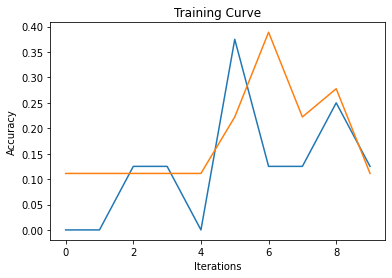

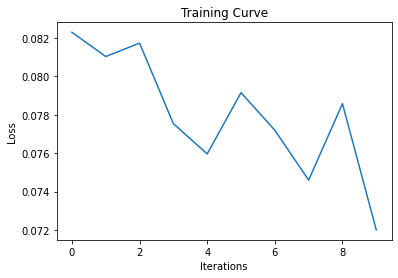

In [ ]:
# First attempt - A standard batch size of 27, epochs being 10 and learning rate being 0.001 to see how it performs
first_model = Hands_CNN()

if torch.cuda.is_available():
  first_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')
train(first_model, train_data, validation_data, batch_size=27, epochs=10, learning_rate=0.001)

We are utilizing the GPU
Epoch:  0 Training Accuracy:  0.2727272727272727 Validation Accuracy:  0.0
Epoch:  1 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.5
Epoch:  2 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.0
Epoch:  3 Training Accuracy:  0.2727272727272727 Validation Accuracy:  0.0
Epoch:  4 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.0
Epoch:  5 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  6 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.0
Epoch:  7 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  8 Training Accuracy:  0.0 Validation Accuracy:  0.0
Epoch:  9 Training Accuracy:  0.0 Validation Accuracy:  0.0
Epoch:  10 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.0
Epoch:  11 Training Accuracy:  0.09090909090909091 Validation Accuracy:  0.0
Epoch:  12 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  13 Trainin

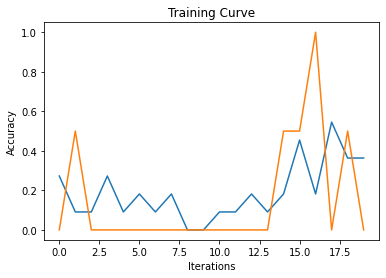

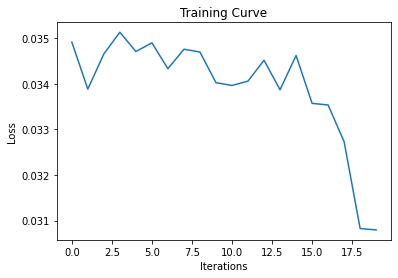

In [ ]:
# Second attempt - Increase batch size to 64 while keeping everything else consistent from the previous attempt
# Also increase epochs to 20
second_model = Hands_CNN()

if torch.cuda.is_available():
  second_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')
train(second_model, train_data, validation_data, batch_size=64, epochs=20, learning_rate=0.001)

We are utilizing the GPU
Epoch:  0 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  1 Training Accuracy:  0.0 Validation Accuracy:  0.5
Epoch:  2 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  3 Training Accuracy:  0.0 Validation Accuracy:  0.0
Epoch:  4 Training Accuracy:  0.2727272727272727 Validation Accuracy:  0.5
Epoch:  5 Training Accuracy:  0.5454545454545454 Validation Accuracy:  0.0
Epoch:  6 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.5
Epoch:  7 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.0
Epoch:  8 Training Accuracy:  0.5454545454545454 Validation Accuracy:  1.0
Epoch:  9 Training Accuracy:  0.5454545454545454 Validation Accuracy:  0.0
Epoch:  10 Training Accuracy:  0.7272727272727273 Validation Accuracy:  0.5
Epoch:  11 Training Accuracy:  0.6363636363636364 Validation Accuracy:  1.0
Epoch:  12 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.5
Epoch:  13 Training Ac

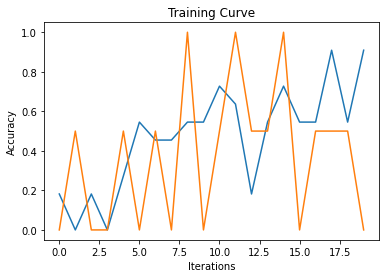

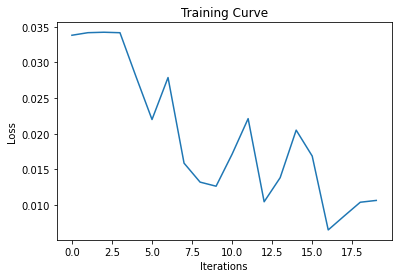

In [ ]:
# Third attempt - Increase learning rate to 0.005 from previous attempt and keep everything else consistent
second_model = Hands_CNN()

if torch.cuda.is_available():
  second_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')
train(second_model, train_data, validation_data, batch_size=64, epochs=20, learning_rate=0.005)

We are utilizing the GPU
Epoch:  0 Training Accuracy:  0.18181818181818182 Validation Accuracy:  0.0
Epoch:  1 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.5
Epoch:  2 Training Accuracy:  0.5454545454545454 Validation Accuracy:  0.0
Epoch:  3 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.5
Epoch:  4 Training Accuracy:  0.5454545454545454 Validation Accuracy:  0.5
Epoch:  5 Training Accuracy:  0.5454545454545454 Validation Accuracy:  0.0
Epoch:  6 Training Accuracy:  0.6363636363636364 Validation Accuracy:  0.5
Epoch:  7 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.5
Epoch:  8 Training Accuracy:  0.7272727272727273 Validation Accuracy:  0.0
Epoch:  9 Training Accuracy:  0.45454545454545453 Validation Accuracy:  0.0
Epoch:  10 Training Accuracy:  0.7272727272727273 Validation Accuracy:  0.5
Epoch:  11 Training Accuracy:  0.7272727272727273 Validation Accuracy:  1.0
Epoch:  12 Training Accuracy:  0.2727272727272727 Validation Accurac

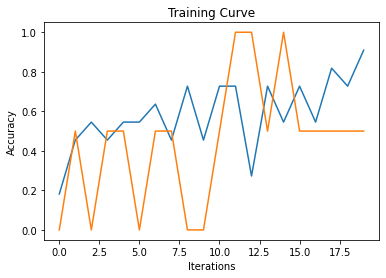

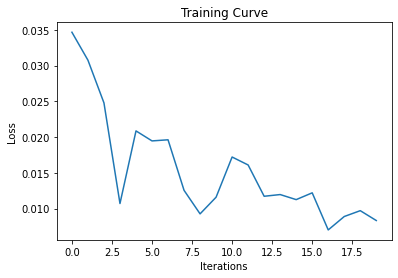

In [ ]:
# Fourth attempt - Change the output channel from 10 to 20

class Hands_CNN(nn.Module):
    def __init__(self):
        super(Hands_CNN, self).__init__()
        self.name = "Hands_CNN"
        # Input channel = 3, output channel = 20, kernel size = 5
        self.conv1 = nn.Conv2d(3, 20, 5)
        # Kernel size and stride are both 2
        self.pool = nn.MaxPool2d(2, 2)
        # Input channel = 20, output channel = 5, kernel size = 5
        self.conv2 = nn.Conv2d(20, 5, 5)
        # Input features = 14045, output features = 32
        self.fc1 = nn.Linear(53 * 53 * 5, 32)
        # Input features = 32, output features = 9
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53 * 53 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


fourth_model = Hands_CNN()

if torch.cuda.is_available():
  fourth_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')
train(fourth_model, train_data, validation_data, batch_size=64, epochs=20, learning_rate=0.005)

We are utilizing the GPU
Epoch:  0 Training Accuracy:  0.10638297872340426 Validation Accuracy:  0.18
Epoch:  1 Training Accuracy:  0.2127659574468085 Validation Accuracy:  0.12
Epoch:  2 Training Accuracy:  0.2978723404255319 Validation Accuracy:  0.12
Epoch:  3 Training Accuracy:  0.40425531914893614 Validation Accuracy:  0.36
Epoch:  4 Training Accuracy:  0.5957446808510638 Validation Accuracy:  0.34
Epoch:  5 Training Accuracy:  0.6808510638297872 Validation Accuracy:  0.46
Epoch:  6 Training Accuracy:  0.6382978723404256 Validation Accuracy:  0.56
Epoch:  7 Training Accuracy:  0.5531914893617021 Validation Accuracy:  0.42
Epoch:  8 Training Accuracy:  0.7446808510638298 Validation Accuracy:  0.56
Epoch:  9 Training Accuracy:  0.6808510638297872 Validation Accuracy:  0.54
Epoch:  10 Training Accuracy:  0.7021276595744681 Validation Accuracy:  0.58
Epoch:  11 Training Accuracy:  0.7872340425531915 Validation Accuracy:  0.56
Epoch:  12 Training Accuracy:  0.5106382978723404 Validatio

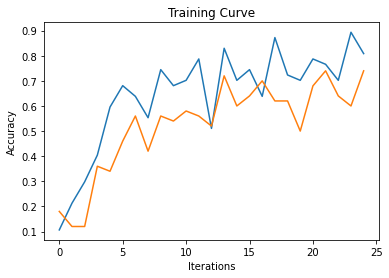

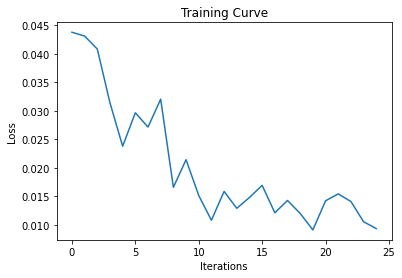

In [ ]:
# My observations:
# The fourth model worsened the validation accuracy, so I'm going to revert the CNN model to 10 output for convolution layers
# The batch size of 60 seemed a bit high but it's necessary to increase it from the original size of 27
# 25 epochs seemed fine as a metric
# Learning rate somewhere between 0.001 and 0.005 would be feasible

# Final attempt

class Hands_CNN(nn.Module):
    def __init__(self):
        super(Hands_CNN, self).__init__()
        self.name = "Hands_CNN"
        # Input channel = 3, output channel = 10, kernel size = 5
        self.conv1 = nn.Conv2d(3, 10, 5)
        # Kernel size and stride are both 2
        self.pool = nn.MaxPool2d(2, 2)
        # Input channel = 10, output channel = 5, kernel size = 5
        self.conv2 = nn.Conv2d(10, 5, 5)
        # Input features = 14045, output features = 32
        self.fc1 = nn.Linear(53 * 53 * 5, 32)
        # Input features = 32, output features = 9
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53 * 53 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


final_model = Hands_CNN()

if torch.cuda.is_available():
  final_model.cuda()
  print('We are utilizing the GPU')
else:
  print('We are not utilizing the GPU')
train(final_model, train_data, validation_data, batch_size=50, epochs=25, learning_rate=0.003)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

As described above, the best model is my final model. The hyperparameters used were a batch size of 50, learning rate of 0.003, 25 epochs, and 10 outputs for the convolution layers. The highest training accuracy it achieved was 89.4% and the highest validation accuracy it achieved was 74%, both respectable results compared to my other models.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
test_load = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=True)
print(get_accuracy(final_model, test_load))

0.64


Test accuracy is 64%.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import os
features_path = '/content/drive/MyDrive/Colab Notebooks/APS360/Lab 3 Features'

batch_size = 1
num_workers = 1

# Saves tensors for training data
train_data_load = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
x = 0
for images, labels in train_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folder = features_path + '/train/' + str(classes[labels])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  x += 1

# Saves tensors for validation data
validation_data_load = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
x = 0
for images, labels in train_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folder = features_path + '/validation/' + str(classes[labels])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  x += 1

# Saves tensors for test data
test_data_load = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
x = 0
for images, labels in train_data_load:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folder = features_path + '/test/' + str(classes[labels])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  x += 1

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
'''output = model(features)
prob = F.softmax(output)'''

train_features = torchvision.datasets.DatasetFolder(features_path + '/train', loader=torch.load, extensions=('.tensor'))
validation_features = torchvision.datasets.DatasetFolder(features_path + '/validation', loader=torch.load, extensions=('.tensor'))
test_features = torchvision.datasets.DatasetFolder(features_path + '/test', loader=torch.load, extensions=('.tensor'))

batch_size = 32
num_workers = 1

train_features_load = torch.utils.data.DataLoader(train_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_features_load = torch.utils.data.DataLoader(validation_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_features_load = torch.utils.data.DataLoader(test_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Verify the features
dataIterator = iter(train_features_load)
features, labels = dataIterator.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
from math import floor
torch.manual_seed(5)

class AlexNetModel(nn.Module):
  def __init__(self, name = "AlexNet_Model"):
    super(AlexNetModel, self).__init__()
    # Input channels = 256, Output channels = 512, Kernel size = 3
    self.conv1 = nn.Conv2d(256, 512, 3)
    # Kernel size = 2, Stride = 2
    self.pool = nn.MaxPool2d(2, 2)

    self.var = floor((6 - 3 + 1)/2)
    self.fc_input = self.var * self.var * 512

    # Input channels = self.var * self.var * 512, Output channels = 32
    self.fc1 = nn.Linear(self.fc_input, 32)
    # Input channels = 32, Output channels = 9
    self.fc2 = nn.Linear(32, 9)

  def forward(self, features):
    var = self.pool(F.relu(self.conv1(features)))
    var = var.view(-1, self.fc_input)
    var = F.relu(self.fc1(var))
    var = self.fc2(var)
    return F.softmax(var, dim=1)

I had one convolution layer, one max pooling layer and two fully connected layers. These layers worked well when I made my CNN model. The convolution layer is massive to take advantage of AlexNet's advantages as it's good for feature mapping. Two fully connected layers allow us to look at our data and make an educated prediction after the max pooling layer has looked at it. The ReLU activation function was used to prevent the vanishing gradient problem from occurring during the backpropagation phase. For the number of channels/hidden units in each layer, I used a kernel size of 3 for the convolution layer. self.var calculatues the input for the first fully connected layer by multiplying by itself and the number of output channels; this all turned out to be: self.var * self.var * 512.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

We are using the GPU
Epoch:  0 Training Accuracy:  0.25 Validation Accuracy:  0.5555555555555556
Epoch:  1 Training Accuracy:  0.575 Validation Accuracy:  0.5555555555555556
Epoch:  2 Training Accuracy:  0.6 Validation Accuracy:  0.6666666666666666
Epoch:  3 Training Accuracy:  0.75 Validation Accuracy:  0.7777777777777778
Epoch:  4 Training Accuracy:  0.8 Validation Accuracy:  0.7777777777777778
Epoch:  5 Training Accuracy:  0.85 Validation Accuracy:  0.8888888888888888
Epoch:  6 Training Accuracy:  0.825 Validation Accuracy:  0.8888888888888888
Epoch:  7 Training Accuracy:  0.925 Validation Accuracy:  0.8888888888888888
Epoch:  8 Training Accuracy:  0.825 Validation Accuracy:  0.8888888888888888
Epoch:  9 Training Accuracy:  0.875 Validation Accuracy:  0.8888888888888888
Epoch:  10 Training Accuracy:  0.8 Validation Accuracy:  0.8888888888888888
Epoch:  11 Training Accuracy:  0.75 Validation Accuracy:  0.8888888888888888
Epoch:  12 Training Accuracy:  0.8 Validation Accuracy:  0.8888

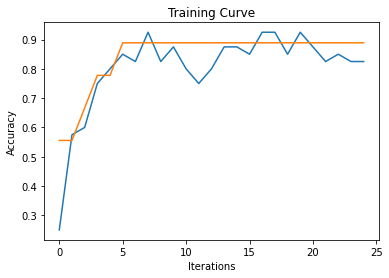

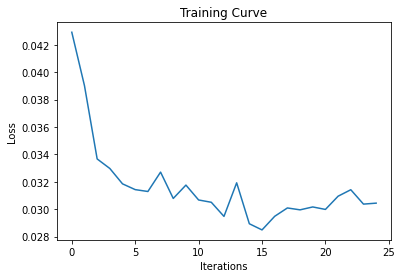

In [ ]:
#tensor = torch.from_numpy(tensor.detach().numpy())

AlexNetCNN = AlexNetModel()

if torch.cuda.is_available():
  print('We are using the GPU')

train(AlexNetCNN, train_features, validation_features, batch_size=50, epochs=25, learning_rate=0.01)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
get_accuracy(AlexNetCNN, test_features_load)

0.8888888888888888

My test feature accuracy for the Alex Net CNN is 88.9% and this is significantly higher than my 64% test accuracy for the CNN I designed. Thus, we can see the benefit of transfer learning from the Alex Net Model, which has already been optimized by experts in the AI field. My CNN model was built spontaneously and doesn't have any transfer learning so understandably its testing accuracy is almost 25% lower.

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# Calculate accuracy with my CNN model
sample_data_path = '/content/drive/MyDrive/Colab Notebooks/APS360/Small Set/Small Training Set/Lab3_Gestures_Summer/train'
sample_data = datasets.ImageFolder(os.path.join(sample_data_path), transform=transform_data)
sample_data_load = torch.utils.data.DataLoader(sample_data, batch_size=27, shuffle=True)
myCNN_accuracy = get_accuracy(final_model, sample_data_load)

# Calculate accuracy with the AlexNet model
features_path = '/content/drive/MyDrive/Colab Notebooks/APS360/Small Set/Small Training Set/Lab3_Gestures_Summer/alex_net'
sample_data_load_alexnet = torch.utils.data.DataLoader(sample_data, num_workers=1, batch_size=1, shuffle=True)
x = 0
for images, labels in sample_data_load_alexnet:
  features = alexnet.features(images)
  featuresTensor = torch.from_numpy(features.detach().numpy())

  folder = features_path + '/samples/' + str(classes[labels])
  if not os.path.isdir(folder):
    os.mkdir(folder)
  torch.save(featuresTensor.squeeze(0), folder + '/' + str(i) + '.tensor')
  x += 1

sample_data_features = torchvision.datasets.DatasetFolder(features_path + '/samples', loader=torch.load, extensions=('.tensor'))
sample_data_features_load = torch.utils.data.DataLoader(sample_data_features, batch_size=batch_size, num_workers=num_workers, shuffle=True)

AlexNet_accuracy = get_accuracy(AlexNetCNN, sample_data_features_load)

print("The accuracy on the sample images using my CNN is: ", myCNN_accuracy)
print("The accuracy on the sample images using the Alex Net CNN is: ", AlexNet_accuracy)

The accuracy on the sample images using my CNN is:  0.7777777777777778
The accuracy on the sample images using the Alex Net CNN is:  0.8888888888888888


As we see with my accuracy print statements, my CNN's accuracy is 77.8% and the Alex Net's accuracy is 88.9%. Thus, the Alex Net CNN is 11.1% better than my designed CNN. The Alex Net CNN performed extremely well with my sample dataset. It only got approximately 1/10 incorrect results. The Alex Net CNN was significantly more robust due to it having access to more data and optimized hyperparamaters from state-of-the-art criterion and optimizer from experts in the AI field. This showcases the advantages of transfer learning and the scope it has on the field of AI.

In [ ]:
# Save the file
%%shell
jupyter nbconvert --to html '/content/Lab3 Gesture Recognition.ipynb'

[NbConvertApp] Converting notebook /content/Lab3 Gesture Recognition.ipynb to html
[NbConvertApp] Writing 1286576 bytes to /content/Lab3 Gesture Recognition.html
